### The objective is to test some images and see the metric results

## Imports

In [1]:
## Imports

from src.PatchImageTool import PatchImageTool
from src.PytorchUtil import PytorchUtil as torchUtil
from src.UpscaleNN import UpscaleNN

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import src.nntools as nt
import skimage.metrics as metrics
import platform  # Import the platform module to detect the OS
import cv2
import math

device = None
if platform.system() == 'Windows':  # Check if the OS is Windows
    import torch_directml  # Import torch_directml only on Windows
    device = torch_directml.device()


if not device:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.empty_cache()
    else:
        device = torch.device('cpu')

print(device)

cuda


## Define the model

In [2]:
small_dataset = None
small_valid_dataset = None
stats_manager = None

lr = 1e-3
batch_size = 512

torch.cuda.empty_cache()
r = UpscaleNN() 
r = r.to(device)

path = "results/superresol-upscale2"

adam = torch.optim.Adam(r.parameters(), lr=lr)

def criterion(y, d):
    return F.mse_loss(y, d)

exp = nt.Experiment(r, 
                    small_dataset, small_valid_dataset, 
                    adam, stats_manager, device, criterion, 
                    batch_size=batch_size,
                    output_dir=path, perform_validation_during_training=True)

1745  vs  1745


## Load image and test

In [3]:
import torchvision.transforms as transforms

image_transforme = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

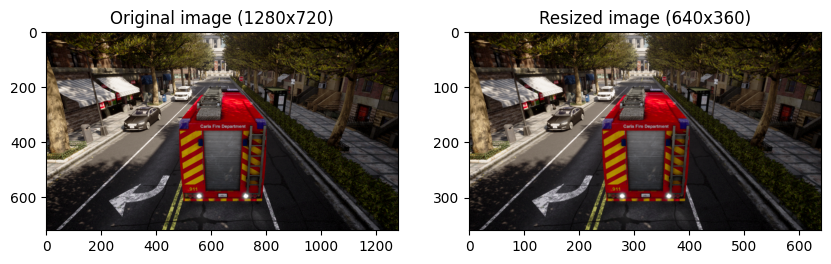

float32


In [4]:
resources_path = "resources"

image_path = os.path.join(resources_path, "example.png")
image = torchUtil.norm_numpy_image(cv2.imread(image_path).astype(np.float32) / 255.0)
image_size = (image.shape[1], image.shape[0])

# divide image image by 2
resized_image = cv2.resize(image, (image_size[0] // 2, image_size[1] // 2))
new_image_size = (resized_image.shape[1], resized_image.shape[0])

# apply transform to image
image_tensor = image_transforme(image).to(device)
resized_tensor = image_transforme(resized_image).to(device)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(torchUtil.tensor_to_image(image_tensor))
ax[0].set_title(f"Original image ({image_size[0]}x{image_size[1]})")

ax[1].imshow(torchUtil.tensor_to_image(resized_tensor))
ax[1].set_title(f"Resized image ({new_image_size[0]}x{new_image_size[1]})")

plt.show()

print(image.dtype)

In [5]:
patch_size = 32

num_patch_width = math.ceil(new_image_size[0] / patch_size)
num_patch_height = math.ceil(new_image_size[1] / patch_size)

num_patch_total = num_patch_width * num_patch_height

resized_patches = PatchImageTool.get_patchs_from_image(resized_tensor, patch_size=patch_size)

print(image_tensor.shape, image_tensor.dtype, resized_patches.dtype)

print(resized_patches.shape, num_patch_width, num_patch_height, num_patch_total)


torch.Size([3, 720, 1280]) torch.float32 torch.float32
torch.Size([240, 3, 32, 32]) 20 12 240


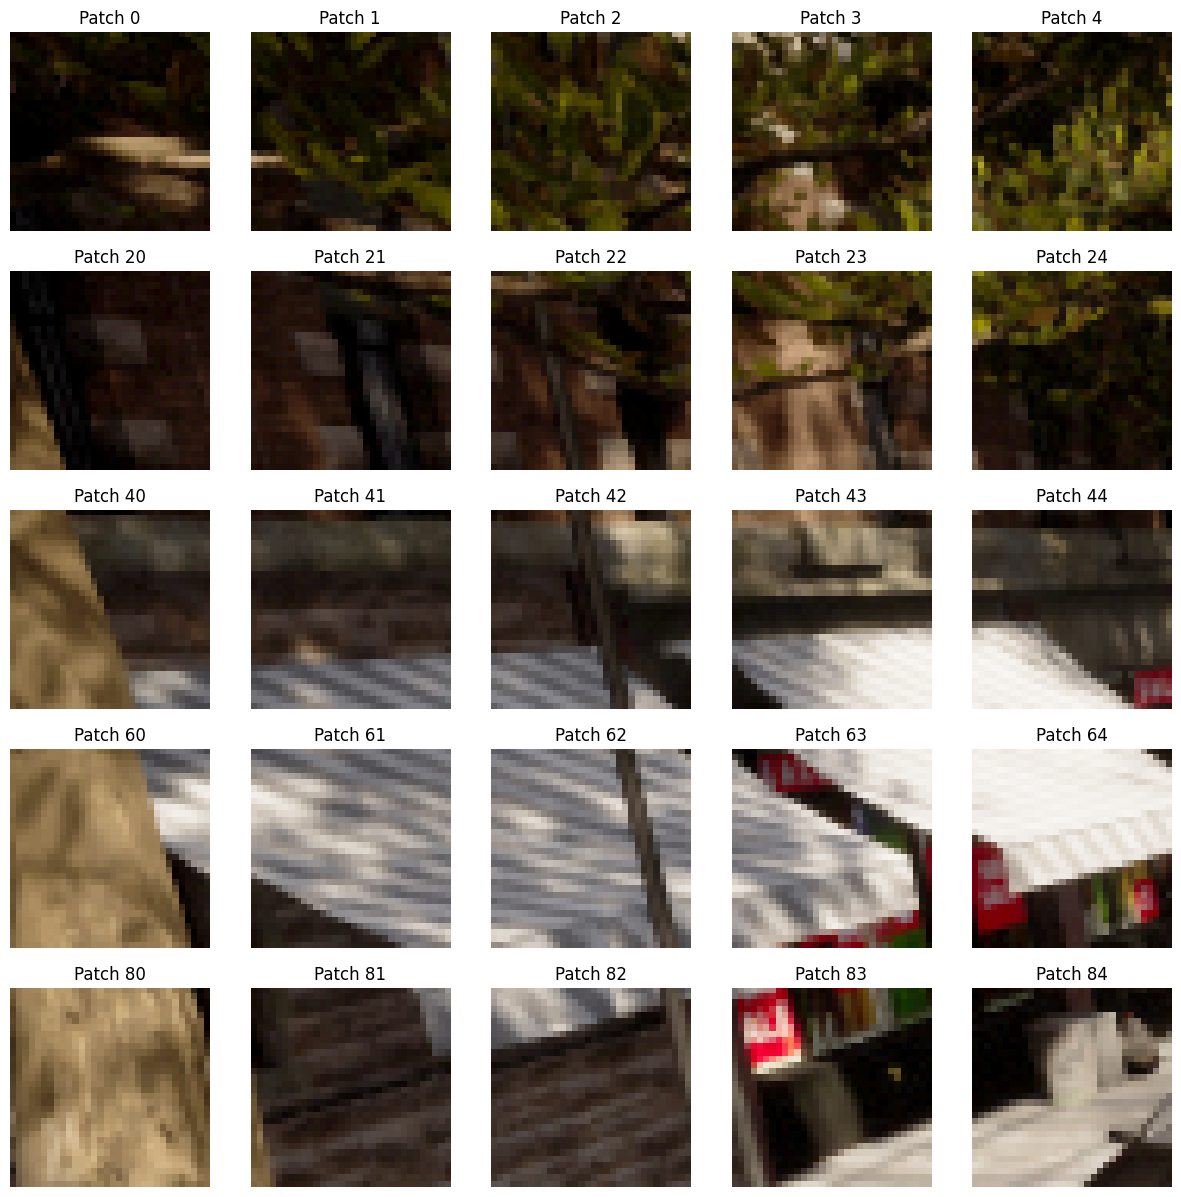

In [6]:
num_cols = min(5, num_patch_width)
num_rows = min(5, num_patch_height)


# Show some image patches
fig, ax = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))
for i in range(num_rows):
    for j in range(num_cols):
        # ndarray
        
        ax[i, j].imshow(torchUtil.tensor_to_image(resized_patches[i * num_patch_width + j]))
        ax[i, j].set_title(f"Patch {i * num_patch_width + j}")
        ax[i, j].axis('off')

In [7]:
from torchvision.transforms.v2 import Resize

def resize_tensor(tensor, size):
    return Resize(size, antialias=True)(tensor)

def resize_tensor_to_numpy(tensor, size):
    return torchUtil.tensor_to_numpy(resize_tensor(tensor, size))

Patch tensor size torch.Size([3, 32, 32]) type torch.float32
Prediction tensor size torch.Size([3, 64, 64]) type torch.float32


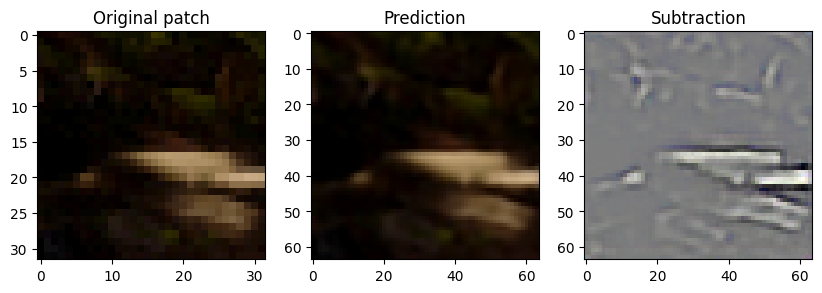

In [8]:
# Make the model predict one patch
patch_index = 0

patch = resized_patches[patch_index].to(device)
print("Patch tensor size", patch.shape, "type", patch.dtype)

with torch.no_grad():
    prediction = exp.net(patch)
    prediction = prediction.squeeze(0)

    print("Prediction tensor size", prediction.shape, "type", prediction.dtype)

    bilinear = resize_tensor_to_numpy(patch, (patch_size * 2, patch_size * 2))

    subtraction = torchUtil.norm_numpy_image(torchUtil.tensor_to_numpy(prediction) - bilinear)

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(torchUtil.tensor_to_image(patch.squeeze(0).cpu()))
ax[0].set_title(f"Original patch")

ax[1].imshow(torchUtil.tensor_to_image(prediction))
ax[1].set_title(f"Prediction")

ax[2].imshow(torchUtil.numpy_to_image(subtraction))
ax[2].set_title(f"Subtraction")

plt.show()

In [9]:
#image_upscaled_torch = exp.net(resized_tensor.to(device)).squeeze(0).cpu()
image_upscaled_torch = PatchImageTool.predict_image_from_image_patches(exp, image_size, resized_patches, device, patch_size=patch_size, sf=2)

image_to_show = torchUtil.tensor_to_image(image_tensor)
image_upscaled = torchUtil.tensor_to_image(image_upscaled_torch)

image_bilinear = resize_tensor_to_numpy(resized_tensor, (image_size[1], image_size[0]))

print(resized_tensor.shape, torchUtil.tensor_to_numpy(image_tensor).shape, image_bilinear.shape, image_size)

substract_image = torchUtil.norm_numpy_image(torchUtil.tensor_to_numpy(image_tensor) - image_bilinear)

torch.Size([3, 360, 640]) (720, 1280, 3) (720, 1280, 3) (1280, 720)


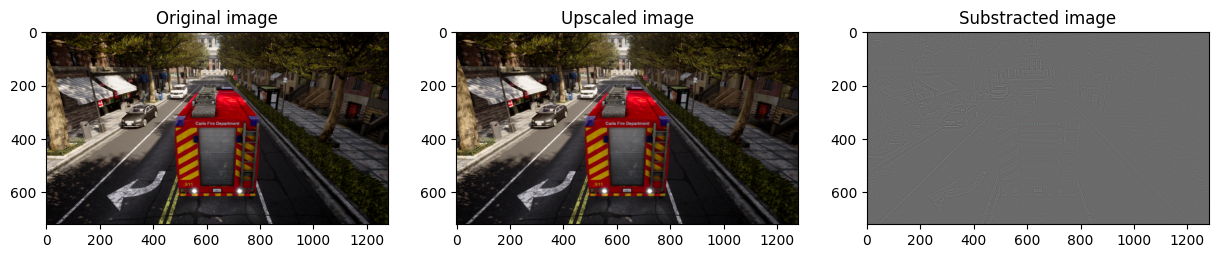

In [10]:
# Show the original image, the predicted and the substracted image

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(image_to_show)
ax[0].set_title(f"Original image")

ax[1].imshow(image_upscaled)
ax[1].set_title(f"Upscaled image")

ax[2].imshow(torchUtil.numpy_to_image(substract_image), vmin=substract_image.min(), vmax=substract_image.max())
ax[2].set_title(f"Substracted image")

plt.show()

In [11]:
# Compute PSNR and SSIM
psnr = metrics.peak_signal_noise_ratio(torchUtil.tensor_to_numpy(image_tensor), torchUtil.tensor_to_numpy(image_upscaled_torch))
ssim = metrics.structural_similarity(torchUtil.tensor_to_numpy(image_tensor), torchUtil.tensor_to_numpy(image_upscaled_torch), \
                                     win_size=7, data_range=1, multichannel=True, channel_axis=2)

print(f"Model PSNR: {psnr} SSIM: {ssim}")

bilinear_psnr = metrics.peak_signal_noise_ratio(torchUtil.tensor_to_numpy(image_tensor), image_bilinear)
bilinear_ssim = metrics.structural_similarity(torchUtil.tensor_to_numpy(image_tensor), image_bilinear, \
                                     win_size=7, data_range=1, multichannel=True, channel_axis=2)

print(f"Bilinear PSNR: {bilinear_psnr} SSIM: {bilinear_ssim}")

PSNR: 32.09494996928087 SSIM: 0.8861374258995056
